In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE


import dataset # my file

C:\Users\soura\anaconda3\envs\machine-learning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset, metadata = tfds.load('CycleGAN',
                              with_info=True, as_supervised=True)

train_face, train_anime = dataset['trainA'], dataset['trainB']
test_face, test_anime = dataset['testA'], dataset['testB']

In [3]:
BUFFER_SIZE = 2100
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [4]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image


def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  image = tf.image.resize(image, [286, 286],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = random_crop(image)
  image = tf.image.random_flip_left_right(image)
  return image

In [5]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [6]:
train_face = train_face.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_anime = train_anime.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_face = test_face.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_anime = test_anime.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
sample_human_face = next(iter(train_face))
sample_anime_face = next(iter(train_anime))

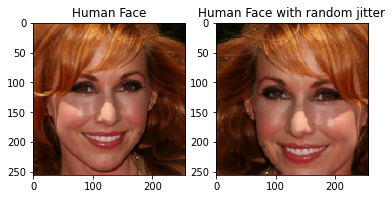

In [8]:
plt.subplot(121)
plt.title('Human Face')
plt.imshow(sample_human_face[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Human Face with random jitter')
plt.imshow(random_jitter(sample_human_face[0]) * 0.5 + 0.5)

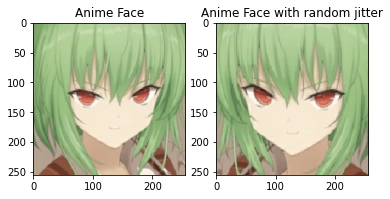

In [9]:
plt.subplot(121)
plt.title('Anime Face')
plt.imshow(sample_anime_face[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Anime Face with random jitter')
plt.imshow(random_jitter(sample_anime_face[0]) * 0.5 + 0.5)

In [10]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

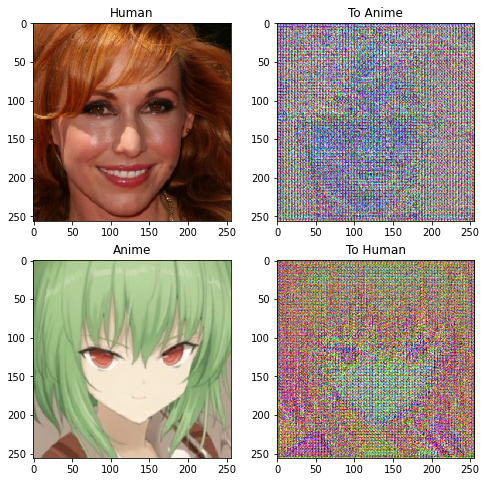

In [11]:
to_anime = generator_g(sample_human_face)
to_human = generator_f(sample_anime_face)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_human_face, to_anime, sample_anime_face, to_human]
title = ['Human', 'To Anime', 'Anime', 'To Human']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

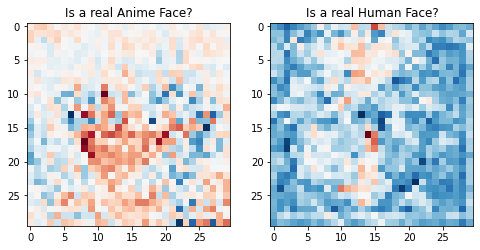

In [12]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real Anime Face?')
plt.imshow(discriminator_y(sample_anime_face)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real Human Face?')
plt.imshow(discriminator_x(sample_human_face)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [13]:
LAMBDA = 10

In [14]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

In [16]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [17]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))  
  return LAMBDA * loss1

In [18]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [19]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [20]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [21]:
EPOCHS = 60

In [22]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [23]:
@tf.function
def train_step(real_x, real_y):
  with tf.GradientTape(persistent=True) as tape:
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [24]:
n = 0
for epoch in range(EPOCHS):
  start = time.time()
  k = 0
  for image_x, image_y in tf.data.Dataset.zip((train_face, train_anime)):
    if k<n:
        k += 1
        continue
    train_step(image_x, image_y)
    if k % 10 == 0:
      print ('.', end='')
    n += 1
    k += 1
    if n==6000:
        n = 0
        break
    if n%100==0:
        break
  clear_output(wait=True)
  # Using a consistent image (sample_human_face) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_human_face)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

"n = 0\nfor epoch in range(EPOCHS):\n  start = time.time()\n  k = 0\n  for image_x, image_y in tf.data.Dataset.zip((train_face, train_anime)):\n    if k<n:\n        k += 1\n        continue\n    train_step(image_x, image_y)\n    if k % 10 == 0:\n      print ('.', end='')\n    n += 1\n    k += 1\n    if n==6000:\n        n = 0\n        break\n    if n%100==0:\n        break\n  clear_output(wait=True)\n  # Using a consistent image (sample_human_face) so that the progress of the model\n  # is clearly visible.\n  generate_images(generator_g, sample_human_face)\n\n  if (epoch + 1) % 5 == 0:\n    ckpt_save_path = ckpt_manager.save()\n    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,\n                                                         ckpt_save_path))\n\n  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,\n                                                      time.time()-start))"

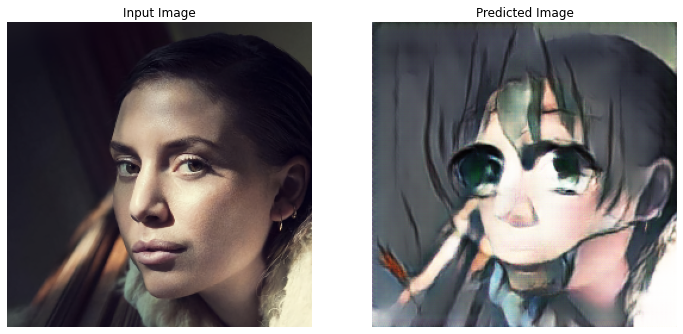

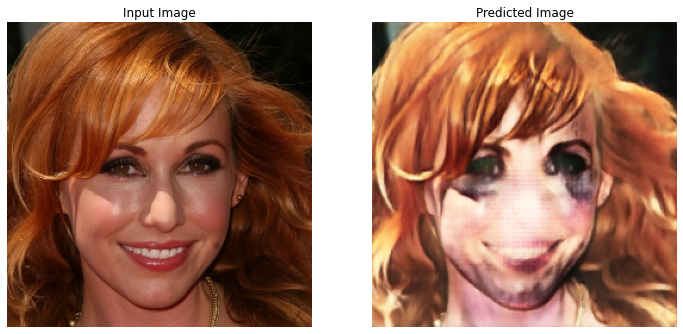

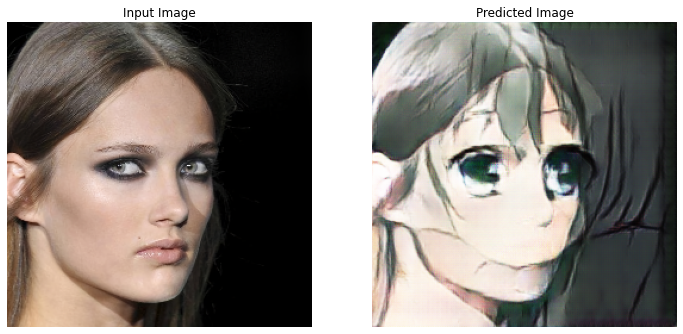

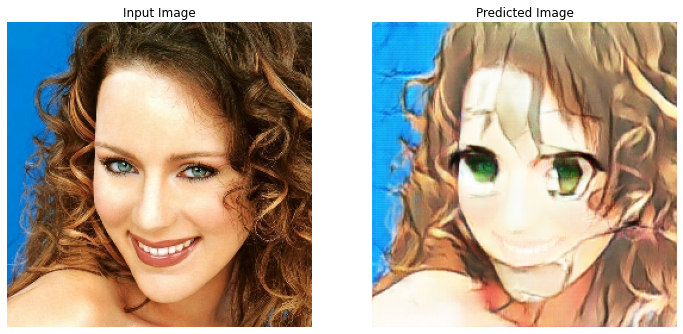

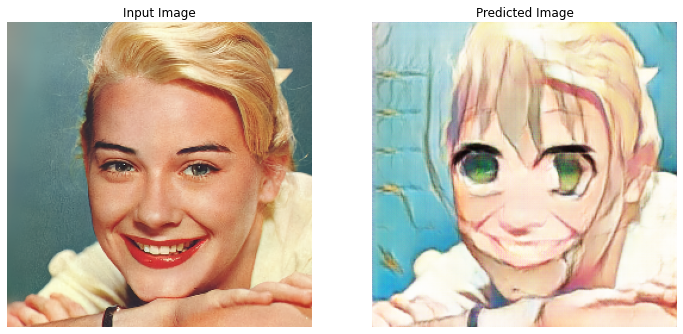

In [25]:
# Run the trained model on the test dataset
for inp in test_face.take(5):
  generate_images(generator_g, inp)